# OES_Data_Preprocessing_and_Autoencoder

Written by: Ketong Shao and Angelo D. Bonzanini

Date: October 2021

* Plot one of the OES spectra to visualize how the data looks like.
* Pre-process the OES spectra for the following autoencoder training.
* Introduce the structure and construction of autoencoders.
* Autoencoder training (training, validation and test data set separation).
* Save and load the trained autoencoder.
* Validate the autoencoder.

## Imports

In [1]:
# General
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/gdrive')

## Load the noisy OES spectra and the corresponding true labels

In [2]:
# The OES spectrum are first normalized by deviding their largest peaks.
# Therefore, each spectra has the highest intensity value as 1.
spec_regen = np.genfromtxt('corrp_specs0.001.csv',delimiter=',')
trans_id = np.genfromtxt('OES_true_labels.csv',delimiter=',')

### Plot the OES data to visualize the structure

Overall data dimensions: (1800, 2000)
-----------------------------------------------
Overall label dimensions: (1800, 3)
-----------------------------------------------
The corresponding existing transitions are: N2(1+): Yes, N2(2+): Yes, NO Gamma: Yes,
-----------------------------------------------


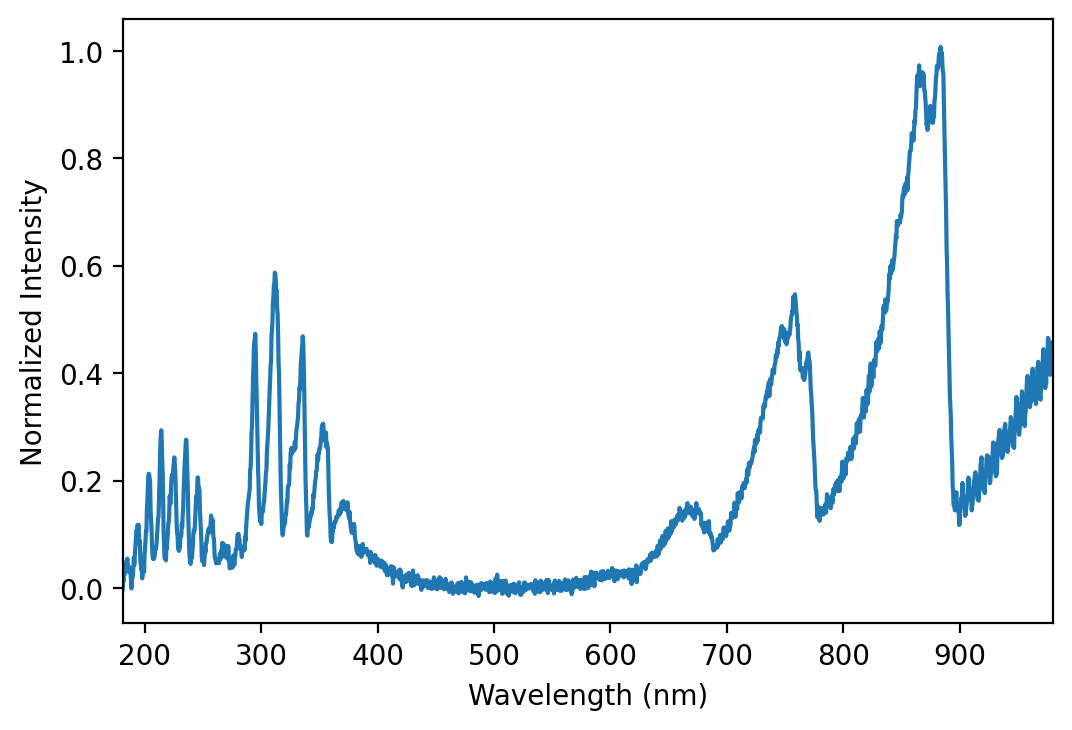

In [26]:
# Print dimensions of each array within the array
print('Overall data dimensions:', spec_regen.shape)
print('-----------------------------------------------')
print('Overall label dimensions:', trans_id.shape)
print('-----------------------------------------------')

# Plot
# Pick one OES spectra to plot
# The Wavelength range is from 181 to 980 nm.
OES_to_pick = 137
print('The corresponding existing transitions are:', 
      'N2(1+):','Yes,' if trans_id[OES_to_pick,0] else 'No,', 
      'N2(2+):','Yes,' if trans_id[OES_to_pick,1] else 'No,',
      'NO Gamma:','Yes,' if trans_id[OES_to_pick,2] else 'No,')
print('-----------------------------------------------')
plt.figure(dpi=200)
plt.plot(np.linspace(181,980,2000),spec_regen[OES_to_pick,:])
plt.xlim((181,980))
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity')
# The y axis shows the relative intensity, the highest value of which is 1. 
plt.show()

### OES Normalization
Normalize the OES data across spectrum.\
This step is necessary for Neural Network training.

In [4]:
# Split the data into training and test dataset. Usually 10% as the test set is a good choice.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(spec_regen, trans_id, test_size=0.1, random_state=42)

In [5]:
# Build the scaler for OES data. Sometimes, 'StandardScaler' could be a good choice.
# It is not necessary and reasonable to normalize the output labels, which are just 1s or 0s.
from sklearn.preprocessing import MinMaxScaler
scaler_OES = MinMaxScaler()
scaled_Xtrain = scaler_OES.fit_transform(X_train)
scaled_Xtest = scaler_OES.transform(X_test)

In [6]:
# Split the training data again, into training and validation data sets. 
# Usually, 20% of the whole data setup is a good choice for validation dataset.
scaled_Xvalidation = scaled_Xtrain[-int(0.2*1800):,:]
scaled_real_Xtrain = scaled_Xtrain[:-int(0.2*1800),:]

## Autoencoder construction
An Autoencoder has an encoder and a decoder.\
The encoder compresses the data into a lower dimension, from which the decoder reconstructs the data.\
Therefore, the input and output of an autoencoder are the same.

In [7]:
# import the necessary packages

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.python.framework import ops

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [8]:
# Define the autoencoder structure
# The structure is adjustable, but the basic shape is like a funnel.

# define the latent space
latent_dim = 10

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = Sequential([
          Flatten(),
        ])
        self.encoder.add(Dense(1500, activation='relu'))
        self.encoder.add(Dense(1000, activation='relu'))
        self.encoder.add(Dense(500, activation='relu'))
        self.encoder.add(Dense(200, activation='relu'))
        self.encoder.add(Dense(70, activation='relu'))
        self.encoder.add(Dense(latent_dim, activation='relu'))
        
        
        
        self.decoder = Sequential([])
        self.decoder.add(Dense(70, activation='relu'))
        self.decoder.add(Dense(200, activation='relu'))
        self.decoder.add(Dense(500, activation='relu'))
        self.decoder.add(Dense(1000, activation='relu'))
        self.decoder.add(Dense(1500, activation='relu'))
        self.decoder.add(Dense(2000, activation='sigmoid'))

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
# compile the autoencoder with specified optimization method 'Adam' here
from tensorflow.keras.optimizers import Adam
autoencoder.compile(optimizer=Adam(learning_rate=0.0000001,), loss='MSE')

# Training start
autoencoder.fit(scaled_real_Xtrain, scaled_real_Xtrain,
                epochs=30000,
                shuffle=True,
                validation_data=(scaled_Xvalidation, scaled_Xvalidation))

In [11]:
# Save the model after training, since the training time is long.
# autoencoder.save('autoencoder_model')

INFO:tensorflow:Assets written to: autoencoder_model/assets


In [12]:
# load the saved model
# autoencoder = tf.keras.models.load_model('autoencoder_model')

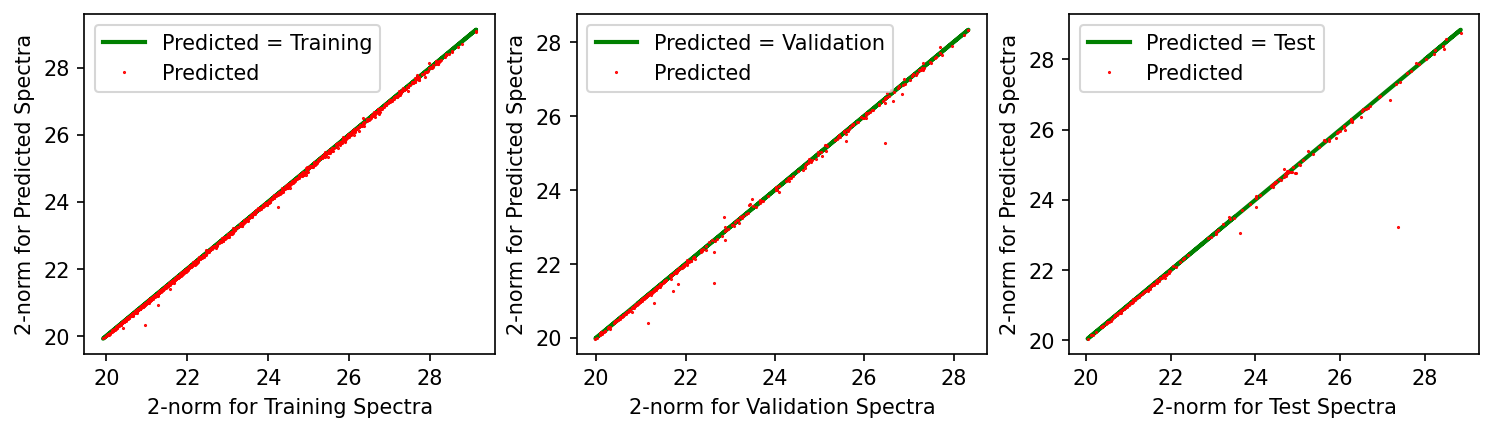


---------- R2 scores ----------
0.9827556936164306


In [24]:
# Plot Parity Plots
# For OES spectra, it is hard to directly plot the parity plots, since the dimension is too large.
# Instead, 2-norm is used.
norm_2_train = np.linalg.norm(scaled_real_Xtrain,axis=1)
norm_2_train_pred = np.linalg.norm(autoencoder.predict(scaled_real_Xtrain),axis=1)
norm_2_validation = np.linalg.norm(scaled_Xvalidation,axis=1)
norm_2_validation_pred = np.linalg.norm(autoencoder.predict(scaled_Xvalidation),axis=1)
norm_2_test = np.linalg.norm(scaled_Xtest,axis=1)
norm_2_test_pred = np.linalg.norm(autoencoder.predict(scaled_Xtest),axis=1)


plt.figure(dpi=150, figsize=(12, 3))
plt.subplot(131)
plt.plot(norm_2_train, norm_2_train, 'g-', lw=2, label = 'Predicted = Training')
plt.plot(norm_2_train, norm_2_train_pred, 'r.', ms=1, label = 'Predicted')
plt.legend()
plt.xlabel('2-norm for Training Spectra')
plt.ylabel('2-norm for Predicted Spectra')
#
plt.subplot(132)
plt.plot(norm_2_validation, norm_2_validation, 'g-', lw=2, label = 'Predicted = Validation')
plt.plot(norm_2_validation, norm_2_validation_pred, 'r.', ms=1, label = 'Predicted')
plt.legend()
plt.xlabel('2-norm for Validation Spectra')
plt.ylabel('2-norm for Predicted Spectra')
#
plt.subplot(133)
plt.plot(norm_2_test, norm_2_test, 'g-', lw=2, label = 'Predicted = Test')
plt.plot(norm_2_test, norm_2_test_pred, 'r.', ms=1, label = 'Predicted')
plt.legend()
plt.xlabel('2-norm for Test Spectra')
plt.ylabel('2-norm for Predicted Spectra')
plt.show()

# Print R^2 score
from sklearn.metrics import r2_score

print('\n---------- R2 scores ----------')
OES_test_R2 = r2_score(norm_2_test, norm_2_test_pred)
print(OES_test_R2)

In [ ]:
# The parith plots show that the trained autoencoder performs well 
# in compressing and reconstructing the OES spectra.
# Therefore, the trained autoencoder can be used as the dimensionality reduction method.